# Figure S2 : DM step response

Response to adding glucose in healthy and DM cells.

In the diabetic parameter set. We adjusted

- PDH capacity
- ETC capacity
- F1 synthase capacity
- Proton leak rate

In [7]:
using DifferentialEquations
using LabelledArrays
using Parameters
using MitochondrialDynamics
using Setfield
import MitochondrialDynamics.Utils: second, μM, mV, mM, Hz, minute

import PyPlot as plt
rcParams = plt.PyDict(plt.matplotlib."rcParams")
rcParams["font.size"] = 12
rcParams["font.sans-serif"] = "Arial"
rcParams["font.family"] = "sans-serif"

"sans-serif"

In [8]:
u0 = LVector(g3p = 2.8μM,
             pyr = 8.5μM,
             nadh_c = 1μM,
             nadh_m = 60μM,
             atp_c = 4000μM,
             adp_c = 500μM,
             ca_m = 0.250μM,
             dpsi = 100mV,
             x2 = 0.20,
             x3 = 0.05)

param = MitoDynNode()

tend = 50minute

function make_paramDM(param; rPDH = 0.5, rETC = 0.75, rHL  = 1.4, rF1  = 0.5)
    paramDM = begin
        p = @set param.pdh.VMAX *= rPDH
        p = @set p.hleak.P_H *= rHL
        p = @set p.f1fo.VMAX *= rF1
        p = @set p.etc.VMAX *= rETC
    end

    return paramDM
end

paramDM = make_paramDM(param)

ussDM = solve(ODEProblem(model!, u0, 50minute, paramDM)).u[end]
uss = solve(ODEProblem(model!, u0, 50minute, param)).u[end]

10-element LArray{Float64, 1, Vector{Float64}, (:g3p, :pyr, :nadh_c, :nadh_m, :atp_c, :adp_c, :ca_m, :dpsi, :x2, :x3)}:
    :g3p => 0.0028959418987092294
    :pyr => 0.008754847026245741
 :nadh_c => 0.0009823894350454892
 :nadh_m => 0.057273163610523384
  :atp_c => 3.594666227160567
  :adp_c => 0.7569404063147739
   :ca_m => 0.0002016747424327822
   :dpsi => 0.0921900330251463
     :x2 => 0.2432964566164939
     :x3 => 0.05827645594093988

In [9]:
function make_affect(x, newdt=0.01)
  return (integrator) -> begin
    integrator.p = setglc(integrator.p, x)
    set_proposed_dt!(integrator, newdt)
  end
end

make_affect (generic function with 2 methods)

In [10]:
t10mM = 20minute
t15mM = 40minute
cb = CallbackSet(
		PresetTimeCallback([t10mM], make_affect(10mM)),
		PresetTimeCallback([t15mM], make_affect(15mM)))


tend = 60minute

sol = solve(ODEProblem(model!, uss, tend, param), callback=cb)
solDM = solve(ODEProblem(model!, ussDM, tend, paramDM), callback=cb);

In [11]:
function plot_fig2s(sol, solDM, tend;
    labels=["Baseline","Diabetic"], figsize=(20,20))

    ll=labels

    ts = range(0.0, tend, length=300)
    tsm = ts ./ 60
    g3p = [sol.(ts, idxs=1) solDM.(ts, idxs=1)]
    pyr = [sol.(ts, idxs=2) solDM.(ts, idxs=2)]
    nadh_c = [sol.(ts, idxs=3) solDM.(ts, idxs=3)]
    nadh_m = [sol.(ts, idxs=4) solDM.(ts, idxs=4)]
    atp_c = [sol.(ts, idxs=5) solDM.(ts, idxs=5)]
    adp_c = [sol.(ts, idxs=6) solDM.(ts, idxs=6)]
    td = atp_c ./ adp_c
    ca_m = [sol.(ts, idxs=7) solDM.(ts, idxs=7)]
    ca_c = cacyto.(adp_c, atp_c, Ref(param), nothing)
    dpsi = [sol.(ts, idxs=8) solDM.(ts, idxs=8)]
    x2 = [sol.(ts, idxs=9) solDM.(ts, idxs=9)]
    x3 = [sol.(ts, idxs=10) solDM.(ts, idxs=10)]
    x1 = getx1.(x2, x3)
    avgDeg = avgdeg.(x2, x3, x1)
    x13 = x1 ./ x3
    for arr in (g3p, pyr, nadh_c, nadh_m, atp_c, adp_c, ca_m, ca_c, dpsi)
        arr .*= 1000
    end

    fig, ax = plt.subplots(3, 3, figsize=figsize)

    ax[1].plot(tsm, g3p)
    ax[1].legend(ll)
    ax[1].set_ylabel("G3P (μM)")
    ax[1].set_xlabel("Time (minute)")
    ax[1].set_title("A", loc="left")
    ax[1].set_ylim(0.0, 8.0)

    ax[4].plot(tsm, pyr)
    ax[4].legend(ll)
    ax[4].set_ylabel("Pyruvate (μM)")
    ax[4].set_xlabel("Time (minute)")
    ax[4].set_title("B", loc="left")
    ax[4].set_ylim(0.0, 500.0)

    ax[7].plot(tsm, nadh_c)
    ax[7].legend(ll)
    ax[7].set_ylabel("Cytosolic NADH (μM)")
    ax[7].set_xlabel("Time (minute)")
    ax[7].set_title("C", loc="left")
    ax[7].set_ylim(0.0, 5.5)

    ax[2].plot(tsm, nadh_m)
    ax[2].legend(ll)
    ax[2].set_ylabel("Mitochondrial NADH (μM)")
    ax[2].set_xlabel("Time (minute)")
    ax[2].set_title("D", loc="left")
    ax[2].set_ylim(0.0, 140.0)

    ax[5].plot(tsm, ca_c)
    ax[5].legend(ll)
    ax[5].set_ylabel("Cytosolic Calcium (μM)")
    ax[5].set_xlabel("Time (minute)")
    ax[5].set_title("E", loc="left")
    ax[5].set_ylim()

    ax[8].plot(tsm, ca_m)
    ax[8].legend(ll)
    ax[8].set_ylabel("Mitochondrial Calcium (μM)")
    ax[8].set_xlabel("Time (minute)")
    ax[8].set_title("F", loc="left")
    ax[8].set_ylim()

    ax[3].plot(tsm, td)
    ax[3].legend(ll)
    ax[3].set_ylabel("ATP/ADP ratio")
    ax[3].set_xlabel("Time (minute)")
    ax[3].set_title("G", loc="left")
    ax[3].set_ylim()

    ax[6].plot(tsm, dpsi)
    ax[6].legend(ll)
    ax[6].set_ylabel("Mitochodrial membrane potential (mV)")
    ax[6].set_xlabel("Time (minute)")
    ax[6].set_title("H", loc="left")
    ax[6].set_ylim()

    ax[9].plot(tsm, avgDeg)
    ax[9].legend(ll)
    ax[9].set_ylabel("Average Node Degree")
    ax[9].set_xlabel("Time (minute)")
    ax[9].set_title("I", loc="left")
    ax[9].set_ylim()

    plt.tight_layout()

    return fig
end

plot_fig2s (generic function with 1 method)

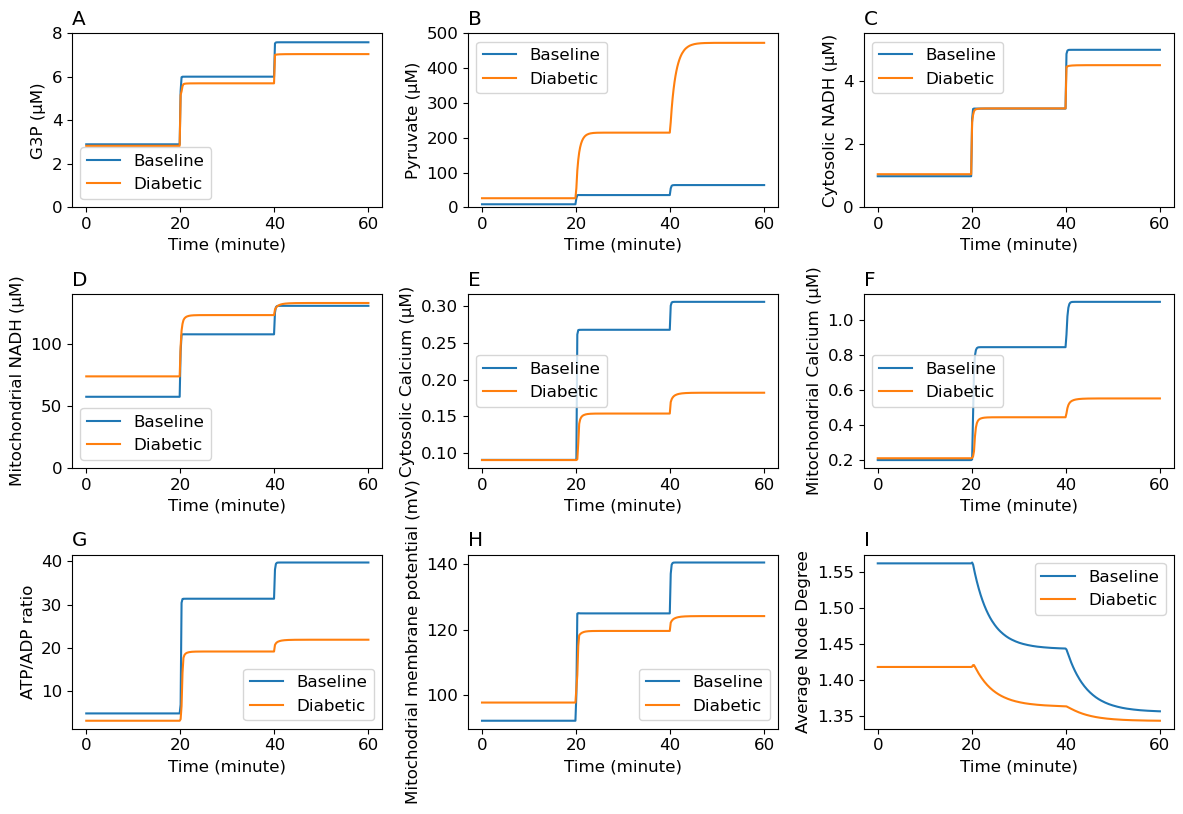

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /home/sosiristseng/.julia/packages/PyCall/3fwVL/src/numpy.jl:67
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


In [12]:
fig2s = plot_fig2s(sol, solDM, tend, figsize=(12,8));

In [ ]:
# Uncomment to generate PDF
# fig2s.savefig("S1_Fig2.pdf")